![](https://upload.wikimedia.org/wikipedia/commons/3/38/Forest_panorama_2.jpg "Machine learning from woods - exploring tree-based ensemble models")

# Machine learning from woods - exploring tree-based ensemble models

### Intro

Ensemble models are definitely a hot topic in machine learning area. They win a lot of data science competitions (ex. organized by Kaggle or DrivenData), they are relatively easy to understand (at least some of them) and they usually doesn’t require large clusters of GPU-accelerated machines to give some reasonable results. Therefore ensemble models definitely deserve being in arsenal of anyone who deals with machine learning problems.

In this blogpost, I will present some basic theory behind three ensemble models: random forest, AdaBoost and gradient tree boosting. Then, we will see how to implement them using one of the most popular machine learning library: Scikit-Learn and how to improve their out-of-the-box performance. You definitely don’t have to be a machine learning expert or statistical/mathematical genius to understand this text, but it will be easier if you are familiar with some main ideas of supervised learning.

### ML Background

Let’s start by briefly introducing two crucial concepts to understand this section, namely: bias and variance. These two describes dependency between model complexity and data. When bias is high it means that model is too general and ignores many important patterns. On the other hand high variance appears when model “focuses” on gentle details too much, losing broader view on data. Finding optimal model is always a trade-off between bias and variance.

In the next sections we will solve classification problems on several datasets. Classification models learn patterns from features that characterize each class, so later given only features of new sample, they can output it’s class label.

General idea behind ensemble models is so simple, that [even pigeons could understand it](https://www.theguardian.com/society/2015/nov/19/pigeons-can-identify-cancerous-tissue-on-x-rays-study-finds). Here’s a recipe: get a set of models, aggregate their predictions and you are ready to go! There are of course many tricks to draw best results from ensembles and we’ll discover some of them later, but for now this intuition is sufficient. There is still one evidently unclear thing: why the title is so “woody”, and what does it mean that models are tree-based? It turns out that most commonly used algorithms to combine into ensembles are decision trees. So before diving into how random forest, AdaBoost and gradient tree boosting works, let’s focus on it’s building blocks. 

#### Decision Trees

To put it simply, decision trees are models that are build on set of boolean conditions defined on features of data, that are composed in tree form. Using given [criterions](http://scikit-learn.org/stable/modules/tree.html#classification-criteria) they find most optimal decision boundaries. One of their advantage is fact, that they are easy to visualize, so let’s do it to clarify how these boundaries interact with each other.

Let’s create simple dataset, where each of 100 samples is defined by only two features (dimensions): X and Y, and there are three classes: “red”, “green” and “blue” using `make_blobs` function from Scikit-Learn library:

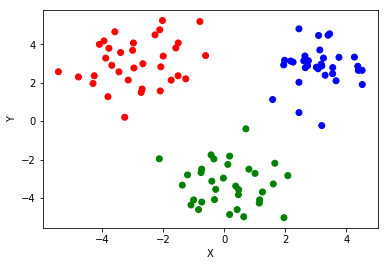

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

%matplotlib inline

RANDOM_STATE = 123  # Ensure repeatability when using randomness
COLORS = ["red", "green", "blue"]
FEATURES_NAMES = ["X", "Y"]

features, labels = make_blobs(centers=[(-3, 3), (0, -3), (3, 3)], random_state=RANDOM_STATE)
labels_colors = [COLORS[label] for label in labels]

plt.scatter(features[:, 0], features[:, 1], c=labels_colors)
plt.xlabel(FEATURES_NAMES[0])
plt.ylabel(FEATURES_NAMES[1])
plt.show()

Then we can create our tree classifier. All Scikit-Learn's share the same API for training: method `fit(features, labels)`.

In [2]:
import sklearn.tree

decision_tree = sklearn.tree.DecisionTreeClassifier()
decision_tree.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Finally we will use graphviz library to investigate the structure of out tree classifier.

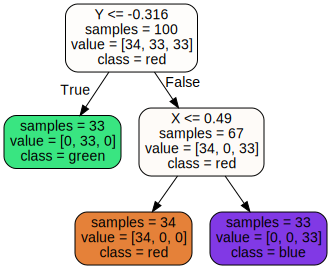

In [3]:
import graphviz

tree_data = sklearn.tree.export_graphviz(decision_tree,
                                         out_file=None,
                                         feature_names=FEATURES_NAMES,
                                         class_names=COLORS,
                                         rounded=True,
                                         filled=True,
                                         impurity=False)
tree_graph = graphviz.Source(tree_data)
tree_graph

First row in node describes decision boundary (not present in leafs), next is number of samples that falls into that node, another one is node’s samples distribution between classes, and the last one is most common class in the node, which in leafs is interpreted as tree output label.

As you can see, decision trees handled well this toy example, and in fact they handle well many real-life problems. Moreover they need very little data preprocessing: ex. scaling data is not needed, because trees will find decision boundaries independently of magnitude of given feature. In addition, decision trees can handle both numerical and categorical data. However they are very prone to overfitting - what means they easily become high-variance models. That results in instability, because small changes in training set can result in major decision boundaries shifts. There are many ways to handle this problem and the most successful one is using more than one tree to build ensemble classifier.

#### Random Forest

You may ask yourself, how using many high-variance models can in fact reduce variance and decrease general error? Let’s imagine you have several datasets, each representing the same phenomenon, but they are taken from different samples of population. If you train decision tree on one of this sets, you won’t have amazing overall performance, but if you will ask set of trees trained on different data to come to a consensus, individual variances will cancel out. But how to train decision trees, so that we have several different models using just one training dataset? That’s where idea of bagging is coming with rescue. Let’s say you have 1000 samples in your training set, and you want to create 25 new training sets to train 25 different decision trees. You just pick randomly 1000 samples (with replacement) from your training set (bag). In new training set, some samples from original one will appear more than once, and some won’t appear at all. If you repeat this procedure 25 times, you’ll have 25 different training sets for building your trees. To get final prediction of ensemble, you just pick the most common output of all trees. You may also use probabilities of classes instead of just labels. They can be taken from distribution of class representants in final tree node (leaf). Using this attitude, your model will favour more confident trees, which sounds reasonable.

But random forest is more than just bagging trees. To make individual trees even more diverse, you randomly limit set of features available when splitting a node. This way, each time when tree tries to find an optimal decision boundary, it “sees” only random subset of all features. This draw take place each time node is split. Common measure is to randomly take $\sqrt{n}$ or $\log_{2}{n}$ features to make a split wheren is original number of features.


#### AdaBoost

There is another family of ensembling methods called boosting, that tackles problem from the other side. This time we will use many weak learners (only slightly better than random guessing), that are high-bias models. Because every base model will be biased in different way, they will cancel out general bias.

Trees that build AdaBoost ensemble, are created sequentially in such a way that new tree should reduce error made by previous models. What is important, once tree is trained, it remains untouched during rest of ensemble training. Trees used in AdaBoost are really shallow, often having only 2 leafs (such trees are called decision stumps). Using trees as base learners is not required by AdaBoost algorithm, but it’s most common practice.

When creating AdaBoost model, all training samples has weights bounded to it. Initially all weights are the same and equal 1N, where N is number of samples. After one tree is trained, weights of wrongly classified samples are increased, and that modified version of dataset is an input to another tree from ensemble. This procedure continues until maximum number of trees is reached or adding new tree don’t result in reducing training error. Output prediction is combination of outputs from all shallow trees, weighted by each tree accuracy. If you are curious what formulas are used for weighting samples, as well as predictions, I highly recommend [blogpost from Jason Brownlee about AdaBoost](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/). 

#### Gradient Tree Boosting

Gradient tree boosting is next member of boosting algorithms family. Similarly to AdaBoost, it is built from set of small trees, but usually slightly deeper than decision stumps. Trees are trained sequentially, just like in AdaBoost, but training of individual trees is not the same.

Trees that are used in gradient tree boosting differ from trees that was described earlier. They are regression trees, so theirs aim is to produce some real value number for each sample. In fact, they are pretty similar to classification decision trees, but they put into leafs samples that have similar (ideally, the same) real values bounded to them. Output value from given leaf is mean value from all samples that get there during training. In case of gradient tree boosting, such trees are constructed for each class independently. They learn to output probability that given sample is a member of given class. Values bounded to samples are either 0 (member of another class) or 1 (member of this class), so perfect tree will output only 0 or 1 and flawed one will produce numbers between 0 and 1.

The main idea behind the algorithm is to iteratively find new trees that minimizes loss function: measure to tell how bad model is. It have to be differentiable, and it’s picked based on problem to solve. For classification it is usually log loss, that is just negative mean of log-probabilities that sample xi is classified as it’s label:
$$loss = -\frac{1}{N}\sum_{i=1}^{N}{\log{p(TRUE LABEL | x_i)}}$$
Having loss value, we can calculate so-called pseudo residuals, that are gradients (partial derivatives) of loss with respect to predictions from previous trees. Pseudo residuals are then plugged instead of labels (ones and zeros in fact) when training a new tree. It does make sense, because new tree will treat differently samples that were completely wrong classified by previous trees and the ones that were pretty close to correct prediction. In addition, trees are parameterized, and these parameters are also optimized during training in order to reduce loss. If you are hungry for more math that explains the whole process you may want to read [wikipedia article](https://en.wikipedia.org/wiki/Gradient_boosting#Algorithm), or [whitepaper](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) from one of the fathers of this method.


### Dataset

To test our algorithms, we will use plain old dataset of Australian Credit Approval. Based on given features of customer (feature names was removed, but it's not important for us), our model will try to predict whether to accept or reject credit card application. There are only two classes: accepted and rejected, so this problem can be named as binary classification. This dataset is available [here](http://mldata.org/repository/data/viewslug/australian/), and we will use an utility Scikit-Learn's function `fetch_mldata` to easily download datasets from mldata.org. We also shuffle data and split it to train and test sets, so after training we can evaluate our model on previously unseen data.

In [4]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

DATASET_NAME = "australian"
TEST_SIZE = 0.2

data_bunch = fetch_mldata(DATASET_NAME)
features, labels = shuffle(data_bunch.data, data_bunch.target, random_state=RANDOM_STATE)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Ensemble models in Scikit-Learn

All models we will test out lives in `sklearn.ensemble` module. Let’s just create them with default constructor parameters, but set random_state to obtain always the same results with the dame data.

In [5]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

models = [
    RandomForestClassifier(random_state=RANDOM_STATE),
    AdaBoostClassifier(random_state=RANDOM_STATE),
    GradientBoostingClassifier(random_state=RANDOM_STATE)
]

### Results

So let's iterate through our models, and check their accuracy (rate of correctly labeled samples), put into Panda's `DataFrame` and check how our models performed!

In [6]:
import pandas as pd

TRAIN_SCORES_ROW = "Train accuracy"
TEST_SCORES_ROW = "Test accuracy"

def evaluate_models(models, model_names=None):
    if not model_names:
        model_names = [type(model).__name__ for model in models]
        
    scores = pd.DataFrame(index=[TRAIN_SCORES_ROW, TEST_SCORES_ROW])
    for model, model_name in zip(models, model_names):
        model.fit(features_train, labels_train)
        scores.at[TRAIN_SCORES_ROW, model_name] = model.score(features_train, labels_train)
        scores.at[TEST_SCORES_ROW, model_name] = model.score(features_test, labels_test)
    return scores

evaluate_models(models)

,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
Train accuracy,0.989130,0.903986,0.981884
Test accuracy,0.862319,0.862319,0.876812


Not bad! As you can see random forest and gradient boosting learned patterns in train set nearly perfectly, although on brand new data all three algorithms performed similarly.

There are more metrics than just accuracy that are worth checking. Let's start with confusion matrix for our best model.

In [7]:
best_model = models[2]
predictions_train = best_model.predict(features_train)
predictions_test = best_model.predict(features_test)

In [8]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_as_data_frame(labels, predictions):
    return pd.DataFrame(confusion_matrix(labels, predictions),
                        index=["Actual rejected", "Actual accepted"],
                        columns=["Predicted rejected", "Predicted accepted"])

In [9]:
confusion_matrix_as_data_frame(labels_train, predictions_train)

,Predicted rejected,Predicted accepted
Actual rejected,300,4
Actual accepted,6,242


In [10]:
confusion_matrix_as_data_frame(labels_test, predictions_test)

,Predicted rejected,Predicted accepted
Actual rejected,71,8
Actual accepted,9,50


Confusion matrix illustrates where our model failed. Ex. we can see that gradient boosting model will decide to accept 8 credit card request that should not have been accepted. Using values from confusion matrix we can calculate number of useful metrics such as precision, recall, false positive rate and so on, and I encourage you to get familiar with [them](https://en.wikipedia.org/wiki/Confusion_matrix) if you are not already.

### Model tuning

#### Introducting hyperparameters

Hyperparameters, are parts of the model that are set explicitly instead of being set during training. They differ between models, and should be set wisely. Scikit-Learn generally uses pretty reasonable ones, but almost always there is some room left for improvement. To get best out of ML models, they shouldn't be treated as magic black-boxes. They have many "knobs" that you can tweak to make them better, and at least high level understanding of how they work let you do so. Let's describe the most important hyperparameters for our three models.

* **Number of trees**

Undoubtly crucial, if not even the most important hyperparameter of all. It's available for all three algorithms. Generally the more trees are used in ensemble - the better, but it's not the ultimate truth. Boosting algorithms can overfit when too many trees are used. Moreover we are limited by time, because of course more trees means longer training and prediction time. Can be set in counstructor (like all other hyperparameters) by the keyword `n_estimators`.

* **Tree size**

We don't want our trees to bee too complicated. Of course random forest relies on high-variance trees, but still enough is as good as a feast (ex. time issues again). On the other hand, boosting algorithms needs shallow trees, maybe even stumps, so we should definitely have the power of controling it. There are three main ways to do so: 1) setting maximum tree depth (`max_depth`) 2) maximum number of leaf nodes (`max_leaf_nodes`) 3) minumum number of samples needed to perform split in node (`min_samples_split`) - recommended for random forest. First two are recommended to set when boosting, last one is especially usefull with random forest. When using AdaBoost they can't be set directly via constructor, but they have to be specified in constructor of `base_estimator` object.

* **Learning rate**

It's present only in boosting methods and defines shrinkage rate of each new added tree. In other words it's factor that every tree contribution is multiplied with. It's highly correlated with the number of trees. Using smaller learning rate forces using higher number of trees to achieve good results. In both described boosting methods it's value is set via keyword `learning_rate`.

* **Subsampling**

Crucial part in terms of random forest. This hyperparameter controls the size of subset of features to pick when splitting a node. It's not however bound only to random forest, since it's can play significant regularization role when using gradient tree boosting, also. Keyword for this hyperaparmeter is `max_features`. When it's float, it represent fraction of all features to pick, when it's integer it's exact number of features to pick. It also could be string: `"sqrt"`, `"log2"`, `"auto"`. Forst two are self-explanatory and `"auto"` is the same as `"sqrt"`. Moreover `GradientBoostingClassifier` support `subsample` keyword, that is float telling what fraction of all samples will be used to train single tree. Setting it to lower values than 1.0 can reduce variance and lead to better results.

#### Hyperparameters search

Before running automated hyperparameter search, let's start with manual part for boosting methods. There are many different approaches and techniques for searching hyperparameters, but since number of trees is so crucial, and it has learning rate bounded to it we will start with those two. We will start with training boosting algorithm with large number of trees (1000 in this example, but for harder tasks it could be thousands), and try to fit them with different, but small learning rates. What is more, we will extract validation set from our training set, to mimic test set, and we will plot dependency between number of trees and some metric. What is a purpose of validation set? We want to add new trees as long at it improves quality but not only on training set but on test set. To avoid overfitting to test set, we extract validation set from our training set which will be used there as test set. This way we can observe, when our algorithm (trained on cut version of training set) starts to overfit, and we can assume that it will behave similarily on full training set. If it's still unclear for you I hope that plots we will make bellow will resolve your doubts.

We start with extracting validation set from our training set (mention `_` after training variables - to not cover original ones):

In [11]:
features_train_, features_valid, labels_train_, labels_valid = train_test_split(
    features_train, labels_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)

We define function that will take class of boosting model and list of learning rates to test. This function fit ensemble consisting of 1000 trees with different learning rates. Boosting algorithms have `staged_predict` method, which produces outputs given by intermediate examples. It means that n-nth staged prediction will be output after using first n trees. We can later find maximum staged accuracy, and decide what number of trees will be most optimal. 

In [12]:
from sklearn.metrics import accuracy_score

N_TREES = 1000
COLORS = ['r', 'g', 'b']

def plot_accuracy(model_class, learning_rates):
    for learning_rate, color in zip(learning_rates, COLORS):
        model = model_class(n_estimators=N_TREES, learning_rate=learning_rate, random_state=RANDOM_STATE)
        model_name = type(model).__name__
        model.fit(features_train_, labels_train_)

        predictions_train = model.staged_predict(features_train_)
        predictions_valid = model.staged_predict(features_valid)

        accuracies_train = [accuracy_score(labels_train_, prediction) for prediction in predictions_train]
        accuracies_valid = [accuracy_score(labels_valid, prediction) for prediction in predictions_valid]

        best_n_trees, best_accuracy = max(enumerate(accuracies_valid, start=1), key=lambda x: x[1])
        print("{}: best valid accuracy={} with {} trees and learning rate={}".format(
            model_name, best_accuracy, best_n_trees, learning_rate))
        
        plt.plot(accuracies_train, "--", c=color, label="Train accuracy, LR: {}".format(learning_rate))
        plt.plot(accuracies_valid, c=color, label="Valid accuracy, LR: {}".format(learning_rate))
        plt.title(model_name)
        plt.xlabel("Number of trees")
        plt.ylabel("Accuracy")
        plt.legend()
    
    plt.show()    

Usually learning rates worth trying are below 0.1, but here we are dealing with small dataset, that may not require hundreds of trees so remembering correlation between leraning rate and number of trees, we will also try bigger one (0.5).

GradientBoostingClassifier: best valid accuracy=0.8918918918918919 with 440 trees and learning rate=0.01
GradientBoostingClassifier: best valid accuracy=0.9009009009009009 with 48 trees and learning rate=0.1
GradientBoostingClassifier: best valid accuracy=0.9009009009009009 with 29 trees and learning rate=0.5


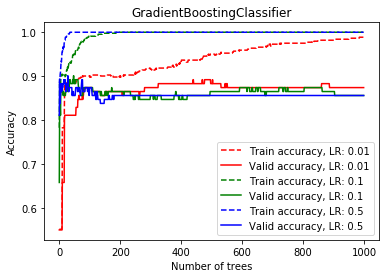

In [13]:
plot_accuracy(GradientBoostingClassifier, [0.01, 0.1, 0.5])

As suspected, we won't need many trees to perform well: 29 base models with learning rate of 0.5 will do the trick. 
We will call this function also AdaBoost remembering that it usually 'likes' slightly higher learning rates.

AdaBoostClassifier: best valid accuracy=0.9009009009009009 with 32 trees and learning rate=0.5
AdaBoostClassifier: best valid accuracy=0.9099099099099099 with 24 trees and learning rate=0.8
AdaBoostClassifier: best valid accuracy=0.918918918918919 with 31 trees and learning rate=1.0


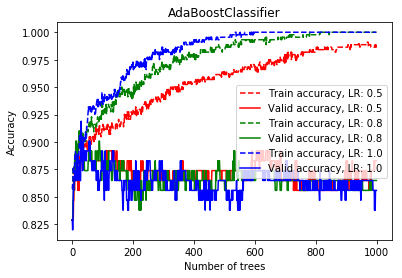

In [14]:
plot_accuracy(AdaBoostClassifier, [0.5, 0.8, 1.0])

Both plots show how boosting methods can overfit: there is a point on each plot after which training accuracy still rises, when validation starts to go down. This mean that adding too many trees causes that model learns patterns only present in training data and fails to generalise problem.

When we've got optimal number of trees and learning rate, now we will tune other hyperparameters. There is plenty of different suggested recomendations on picking right parameters over the web. We will use set of potential good parameters from table available [here](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/). We will perform so-called Grid Search, so we will try every possible combination of theese parameters, and pick the one that perform the best. During random search [cross-validation](http://www.ritchieng.com/machine-learning-cross-validation/) is performed. At first, training set is divided into n parts (defined by keyword `cv`). Then there are n turns when 1 part is used as validation test and the rest is used as training set. After n validation turns, a mean score (ex. accuracy) is somputed, and configuration that ensured the best mean test (validatScikit-learn provides handy API to do so, and we can even get the best performing model straight away. Note: this code may take a bit longer time: delete some values to minimize number of combinations (ex. maximum values for `max_depth` `subsample` and `max_features`)

In [15]:
from sklearn.model_selection import GridSearchCV

NUM_FOLDS = 5

gradient_boosting_params = {
    "n_estimators": [29],
    "learning_rate": [0.5],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.4, 0.6, 0.8, 1.0],
    "max_features": [0.5, 0.75, 1.0]
}

random_search = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE),
                             param_grid=gradient_boosting_params,
                             cv=NUM_FOLDS)
random_search.fit(features_train, labels_train)
best_gb_model = random_search.best_estimator_
best_gb_params = random_search.best_params_

In [16]:
best_gb_params

{'learning_rate': 0.5,
 'max_depth': 6,
 'max_features': 0.75,
 'n_estimators': 29,
 'subsample': 0.8}

To raise a tension, we won't evaluate accuracy of our tuned model now. Firstly let's tune random forest and AdaBoost 

If we don't have such amazing table with hyperparameters, or it just completely fail on your data there is an alternative to grid search: random search. Instead of trying all combinations of proposed values of parameters, you just define some ranges, where to find them and then randomly pick several sets of parameters. At first, this may sound strange but look at picture below, taken from [this paper](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) and consider model with only two hyperparameters. Green curve on the top and yellow one on the left of rectangles, are ex. function of accuracy in the terms of each of them. Grid search ensure even coverage of this two-dimensional space, but it covers only three points on each of hyperparameter space. When we use random search, we got much more better coverage of search on each individual hyperparameter. It is especially essential, when one hyperparameter has evident maximum comparing to other one.

<img src="http://cs231n.github.io/assets/nn3/gridsearchbad.jpeg" alt="Drawing" style="width: 500px;"/>

Now let's define ranges of iterest for remaining classifiers, and number of random trials (equal to combinations in previous grid search).

In [17]:
from functools import reduce
from operator import mul

random_trials = reduce(mul, (len(values) for _, values in gradient_boosting_params.items()))

random_forest_params = {
    "n_estimators": range(5, 500),
    "min_samples_split": range(2, 50),
    "max_features": [x / 10 for x in range(1, 11)]
}

adaboost_params = {
    "n_estimators": range(25, 50),
    "learning_rate": [x / 100 for x in range(80, 101)],
    "base_estimator__max_depth": range(1, 3),   
}

And define function to retrieve best model based on random search.

In [18]:
from sklearn.model_selection import RandomizedSearchCV

def find_best_model(model, params):
    random_search = RandomizedSearchCV(model,
                                       param_distributions=params,
                                       n_iter=random_trials,
                                       cv=NUM_FOLDS,
                                       random_state=RANDOM_STATE)
    random_search.fit(features_train, labels_train)
    print(random_search.best_params_)
    return random_search.best_estimator_

Finally, let's get tuned versions of random forest and AdaBoost, and compare it with gradient boosting. Notice taht we have to explicitely define AdaBoost base model to  tinker with it's parameters.

In [19]:
best_rf_model = find_best_model(RandomForestClassifier(random_state=RANDOM_STATE),
                                random_forest_params)
best_ab_model = find_best_model(AdaBoostClassifier(sklearn.tree.DecisionTreeClassifier(),
                                                   random_state=RANDOM_STATE),
                                adaboost_params)
                         

evaluate_models([best_rf_model, best_ab_model, best_gb_model])

{'n_estimators': 35, 'min_samples_split': 2, 'max_features': 0.5}
{'n_estimators': 25, 'learning_rate': 0.97, 'base_estimator__max_depth': 1}


,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
Train accuracy,1.000000,0.893116,1.000000
Test accuracy,0.876812,0.884058,0.898551


Hooray! We have slight improvements on each of our classifiers. You can of course try different hyperameter's ranges or use random search with gradient boosting. Moreover, there are many more parameters to tune, but I would argue, that you should at least start with those. They represent different aspects of out models and are rather easy to interpret. BAYESIAN OPTIMALIZATION???

#### Ensembling ensembles

Now, we will go one step further and try to gather predictions from our tuned ensembles and try to ensemble them! To do so, we will use Scikit-Learn's `VotingClassifier`. It can make decision based on most frequest decision (hard voting) or predicted probabilities from models (soft voting). We will try both and check if we can squeeze a bit more from our fine-tuned models.

In [28]:
import warnings

from sklearn.ensemble import VotingClassifier

warnings.filterwarnings("ignore", category=DeprecationWarning)

voting_models = [
    ("random forest", best_rf_model),
    ("AdaBoost", best_ab_model),
    ("gradient boosting", best_gb_model)
]

hard_voting_model = VotingClassifier(voting_models, voting="hard")
soft_voting_model = VotingClassifier(voting_models, voting="soft")

evaluate_models([hard_voting_model, soft_voting_model], model_names=["Hard voting", "Soft voting"])

,Hard voting,Soft voting
Train accuracy,1.000000,1.000000
Test accuracy,0.905797,0.898551


Another tiny step for perfect predictions done! You can also weight models, perform hyperparameter search directly on `VotingClassifier` and more. If you want to do so, [Scikit-Learn's documentation](http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) is a must for you.

### Summary